In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle
import pandas as pd
from torch.utils.data import DataLoader, random_split
import requests
import matplotlib.pyplot as plt

In [2]:
prediction_distance = 1
slice_size = 150
forward_exit_threshold = 50

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(slice_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 64)
        self.fc7 = nn.Linear(64, 64)
        self.fc8 = nn.Linear(64, 64)
        self.fc9 = nn.Linear(64, 64)
        self.fc10 = nn.Linear(64, 64)
        self.fc11 = nn.Linear(64, 64)
        self.fc12 = nn.Linear(64, 64)
        self.fc13 = nn.Linear(64, 3)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        x = torch.tanh(self.fc10(x))
        x = torch.tanh(self.fc11(x))
        x = torch.tanh(self.fc12(x))
        x = torch.tanh(self.fc13(x))
        return x

net = Net()
GPU = torch.device("cuda")
net.to(GPU)

Net(
  (fc1): Linear(in_features=150, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=64, bias=True)
  (fc8): Linear(in_features=64, out_features=64, bias=True)
  (fc9): Linear(in_features=64, out_features=64, bias=True)
  (fc10): Linear(in_features=64, out_features=64, bias=True)
  (fc11): Linear(in_features=64, out_features=64, bias=True)
  (fc12): Linear(in_features=64, out_features=64, bias=True)
  (fc13): Linear(in_features=64, out_features=3, bias=True)
)

In [4]:
loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0001)

In [5]:
# for everyone reading this:
# have a moment of silence to celebrate me getting this code working FIRST TRY!!1!1!11!
class Dataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.prices = self.df["Close"]
        
        self.slices = []
        self.predictions = []
        
        # [1, 0, 0]   --->   up
        # [0, 1, 0]   --->   forward
        # [0, 0, 1]   --->   down
        
        for x in tqdm(range(len(self.prices) - (prediction_distance + slice_size))):
            self.slice = torch.tensor(self.prices[x : x + slice_size].tolist(), dtype=torch.float32, device=GPU)
            self.slices.append(self.slice)
            
            if abs(self.prices[x + slice_size] - self.prices[x + slice_size + prediction_distance]) >= forward_exit_threshold:
                if self.prices[x + slice_size] >= self.prices[x + slice_size + prediction_distance]:
                    self.prediction = torch.tensor((0, 0, 1), dtype=torch.float32, device=GPU)
                else:
                    self.prediction = torch.tensor((1, 0, 0), dtype=torch.float32, device=GPU)
            else:
                self.prediction = torch.tensor((0, 1, 0), dtype=torch.float32, device=GPU)
            
            self.predictions.append(self.prediction)

    def __len__(self):
        return len(self.predictions)
        
    def __getitem__(self, idx):
        return self.slices[idx], self.predictions[idx]

In [6]:
def train_nn(question_tensor, answer_tensor, model, loss=loss, optimizer=optimizer):
    optimizer.zero_grad()
    outputs = model(question_tensor)
    loss = loss(outputs, answer_tensor)
    loss.backward()
    optimizer.step()

In [7]:
def scan_market(currency, interval, scan_size):
    base_url = r'https://api.coingecko.com/api/v3'
    endpoint = f'/coins/{currency}/market_chart?vs_currency=usd&days=1&interval={interval}'
    
    response = requests.get(base_url + endpoint)
    
    if response.status_code == 200:
        data = response.json()
        closing_prices = [data_point[1] for data_point in data["prices"]]
        return closing_prices[-scan_size:]
    else:
        raise Exception(f'Request failed with status code {response.status_code}')

In [8]:
train_test_split = 0.8
batch_size = 4096

dataset = Dataset(r"C:\Users\user\Desktop\simulation\tooki\NETMEM github repo\BTC-USD (1).csv")

train_size = int(train_test_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████| 2996/2996 [00:00<00:00, 6421.16it/s]


In [11]:
#net.train()

for y in tqdm(range(500)):
    for x in enumerate(train_data_loader):
        train_nn(x[1][0], x[1][1], net)

100%|██████████| 500/500 [00:03<00:00, 134.20it/s]


In [12]:
#net.eval()

errors = 0

for x in tqdm(enumerate(test_data_loader)):
    if torch.argmax(net(x[1][0])) != torch.argmax(x[1][1]):
        errors += 1

print(f"NET ACC RATE   --->   {100 - 100 * errors / len(test_dataset):.2f} %")
print(f"NET ERR RATE   --->   {100 * errors / len(test_dataset):.2f} %")
print(f"RND ACC RATE   --->   {100 - 100 * (3 - 1) / 3:.2f} %")
print(f"RND ERR RATE   --->   {100 * (3 - 1) / 3:.2f} %")

600it [00:00, 1116.08it/s]

NET ACC RATE   --->   41.50 %
NET ERR RATE   --->   58.50 %
RND ACC RATE   --->   33.33 %
RND ERR RATE   --->   66.67 %


In [11]:
#import time

In [12]:
#with open(r"C:\Users\user\Desktop\AUTOENCODER\log.txt", "a+") as file:
#    while True:
#        file.write(f"{time.ctime()}   |   {str(net(torch.tensor(scan_market('bitcoin', '1m', 250), dtype=torch.float32, device=GPU)))}")
#        time.sleep(120)

tensor([-0.3313,  0.5740, -0.4141], device='cuda:0', grad_fn=<TanhBackward0>)


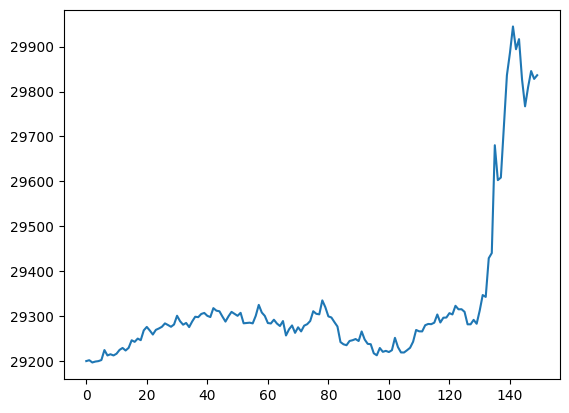

In [13]:
print(net(torch.tensor(scan_market('bitcoin', '1h', slice_size), dtype=torch.float32, device=GPU)))
plt.plot(scan_market('bitcoin', '1h', slice_size))